## Analyse des séries chronologiques - Partie 4 : Modèles ARCH et GARCH

In [1]:
import os
import sys

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms
from arch import arch_model


import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [19]:
from backtester.dataSource.yahoo_data_source import YahooStockDataSource
startDateStr = '2014/12/31'
endDateStr = '2017/12/31'
cachedFolderName = 'yahooData/'
dataSetId = 'testPairsTrading'
instrumentIds = ['^GSPC']
ds = YahooStockDataSource(cachedFolderName=cachedFolderName,
                            dataSetId=dataSetId,
                            instrumentIds=instrumentIds,
                            startDateStr=startDateStr,
                            endDateStr=endDateStr,
                            event='history')
data = ds.getBookDataByFeature()['adjClose']
# log returns
lrets = np.log(data/data.shift(1)).dropna()

Processing data for stock: ^GSPC
20% done...
40% done...
60% done...
80% done...


In [3]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

#### Hétéroscédasticité conditionnelle
La principale motivation pour étudier l'hétéroscédasticité conditionnelle en finance est celle de la volatilité des rendements des actifs.

Un ensemble de variables aléatoires est hétéroscédastique s'il existe certains groupes, ou sous-ensembles, de variables au sein de l'ensemble plus large qui ont une variance différente des autres variables.

En finance, une augmentation de la variance peut être corrélée à une nouvelle augmentation de la variance. Par exemple, un jour où les marchés des actions subissent une baisse importante, des ordres de vente automatisés de gestion des risques dans des portefeuilles longs seulement sont déclenchés, ce qui entraîne une nouvelle baisse du prix des actions au sein de ces portefeuilles, ce qui entraîne une volatilité à la baisse significative.

Ces périodes de "vente", ainsi que de nombreuses autres formes de volatilité, entraînent une hétéroscédasticité qui est corrélée en série et donc conditionnée par des périodes de variance accrue. Nous disons donc que ces séries sont hétéroscédastiques conditionnelles.

L'un des aspects difficiles des séries hétéroscédastiques conditionnelles est que les tracés ACF d'une série avec volatilité peuvent encore sembler être une réalisation de bruit blanc discret stationnaire. Ceci malgré le fait que la série est très certainement non stationnaire car sa variance n'est pas constante dans le temps.

Pour incorporer CH dans notre modèle, nous pouvons créer un modèle qui utilise un processus autorégressif pour la variance elle-même - un modèle qui tient réellement compte des changements de la variance dans le temps en utilisant les valeurs passées de la variance.

C'est la base du modèle hétéroscédastique conditionnel autorégressif (ARCH).

#### Modèles hétéroscédastiques conditionnels autorégressifs - ARCH(p)
Les modèles ARCH(p) peuvent être considérés comme un simple modèle AR(p) appliqué à la variance d'une série temporelle.

$$Var(\epsilon_t) = \alpha_0 + \alpha_1Var(\epsilon_{t-1})+...+\alpha_pVar(\epsilon_{t-p})+w_t$$
La série chronologique réelle est donnée par :

$$\epsilon_t = w_t\sqrt{\alpha_0 + \alpha_1\epsilon_{t-1}^2+...+\alpha_p\epsilon_{t-p}^2}$$
Pour ARCH(1), cela se traduit par : $$\epsilon_t = w_t\sqrt{\alpha_0+\alpha_1\epsilon_{t-1}^2}$$

#### Quand appliquer ARCH(p) ?
Lorsque nous essayons d'ajuster un modèle AR(p) et que nous nous préoccupons de la décroissance du retard $p$ sur un tracé ACF de la série, nous pouvons appliquer la même logique au carré des résidus. Si nous constatons que nous pouvons appliquer un AR(p) à ces résidus carrés, nous avons alors une indication qu'un processus ARCH(p) peut être approprié.

Notez que ARCH(p) ne doit être appliqué qu'à une série pour laquelle un modèle approprié a déjà été ajusté et qui est suffisante pour que les résidus ressemblent à un bruit blanc discret. Comme nous ne pouvons dire si ARCH est approprié ou non qu'en élevant les résidus au carré et en examinant le FAC, nous devons également nous assurer que la moyenne des résidus est égale à zéro.

ARCH ne devrait jamais être appliqué qu'aux séries qui n'ont pas de tendances ou d'effets saisonniers, c'est-à-dire qui n'ont pas de corrélation (évidente) en série. ARIMA est souvent appliqué à une telle série, et ARCH peut alors être un bon ajustement.

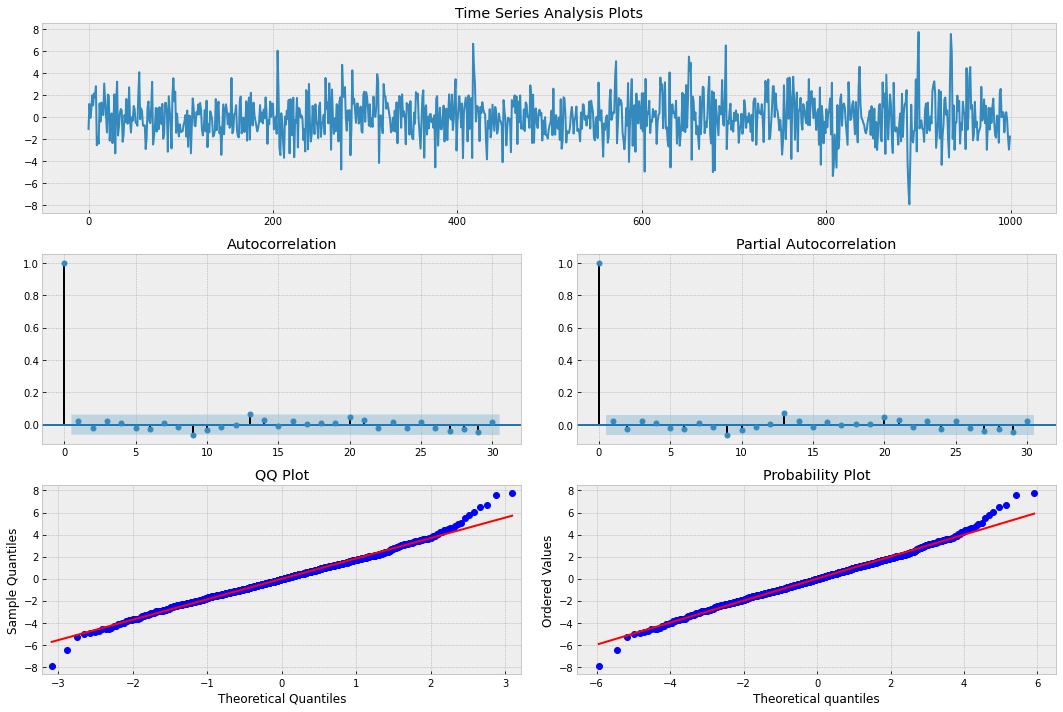

In [4]:
# Simulate ARCH(1) series
# Var(yt) = a_0 + a_1*y{t-1}**2
# if a_1 is between 0 and 1 then yt is white noise

np.random.seed(13)

a0 = 2
a1 = .5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))

# simulated ARCH(1) series, looks like white noise
tsplot(y, lags=30)


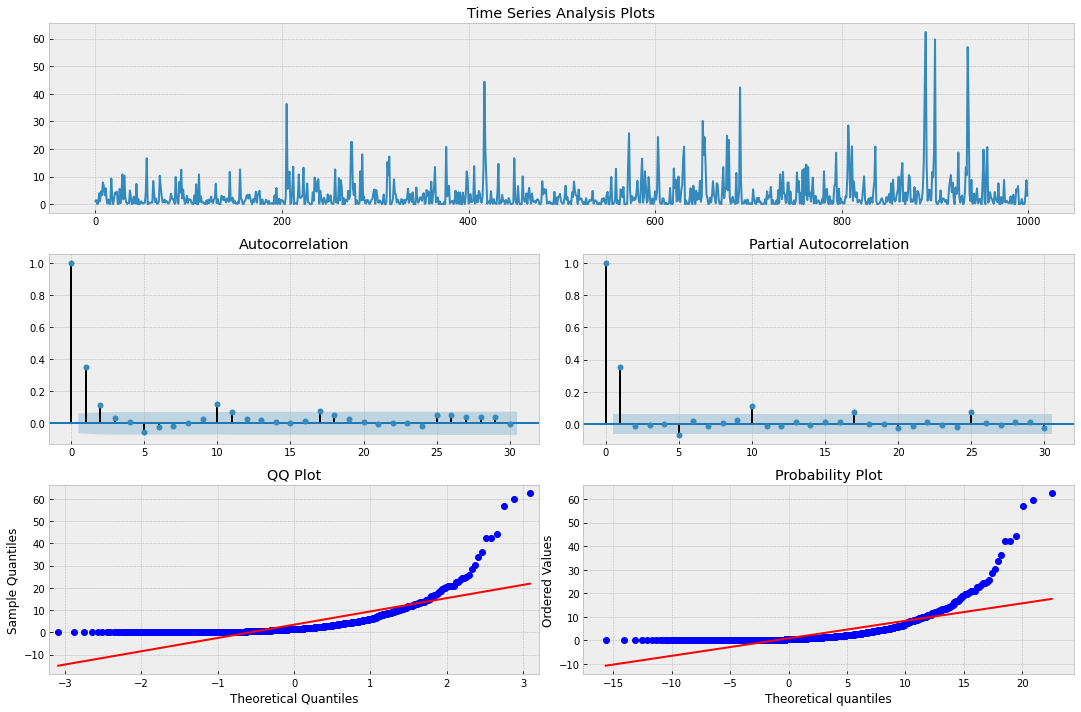

In [5]:
tsplot(y**2, lags=30)

Remarquez que la série chronologique ressemble à un bruit blanc. Cependant, lorsque nous traçons le carré de la série, l'ACF et le PACF semblent montrer une signification au décalage 1, ce qui indique qu'un modèle AR(1) pour la variance peut être approprié.

Une question évidente à poser à ce stade est que si nous allons appliquer un processus AR(p) à la variance, pourquoi pas également un modèle MA(q) de moyenne mobile ? Ou un modèle mixte tel que ARMA(p,q) ?

C'est en fait la motivation du modèle ARCH généralisé, connu sous le nom de GARCH

#### Modèles autorégressifs généralisés hétéroscédastiques conditionnels - GARCH(p,q)
GARCH(p, q) est un modèle ARMA appliqué à la variance d'une série temporelle, c'est-à-dire qu'il comporte un terme autorégressif et un terme de moyenne mobile. Le modèle AR(p) modélise la variance des résidus (erreurs quadratiques) ou simplement le carré de notre série temporelle. La partie MA(q) modélise la variance du processus.

$$\epsilon_t = \sigma_t w_t$$
Où $w_t$ est un bruit blanc discret, avec une variance moyenne et unitaire nulle, et $\sigma^2$ est donné par :

$$\sigma_t^2=\alpha_0+\sum_{i=1}^{p}\alpha_i\epsilon_{t-i}^2+\sum_{j=1}^{q}\beta_j\sigma_{t-j}^2$$
Où $\alpha_i$ et $\beta_j$ sont les paramètres du modèle. Pour GARCH(1,1), $\sigma^2$ est :

$$\sigma_t^2=\alpha_0+\alpha_1\epsilon_{t-1}^2+\beta_1\sigma_{t-1}^2$$
$\alpha_1 + \beta_1$ doit être inférieur à 1 ou le modèle est instable. Nous pouvons simuler un processus GARCH(1, 1) ci-dessous.

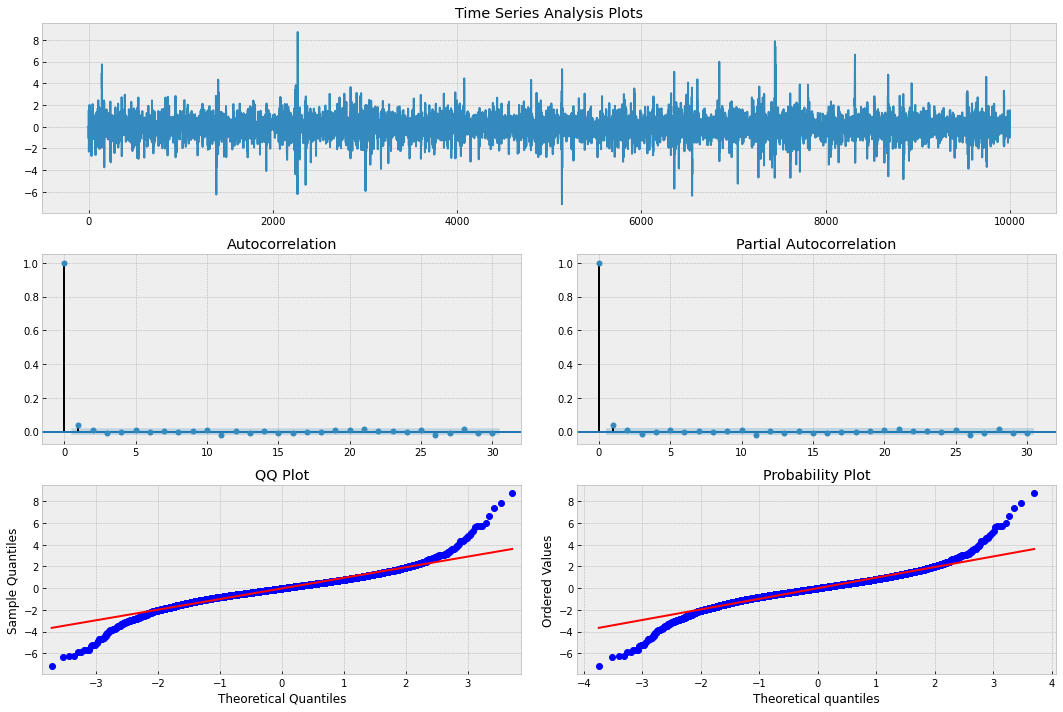

In [6]:
# Simulating a GARCH(1, 1) process

np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

_ = tsplot(eps, lags=30)

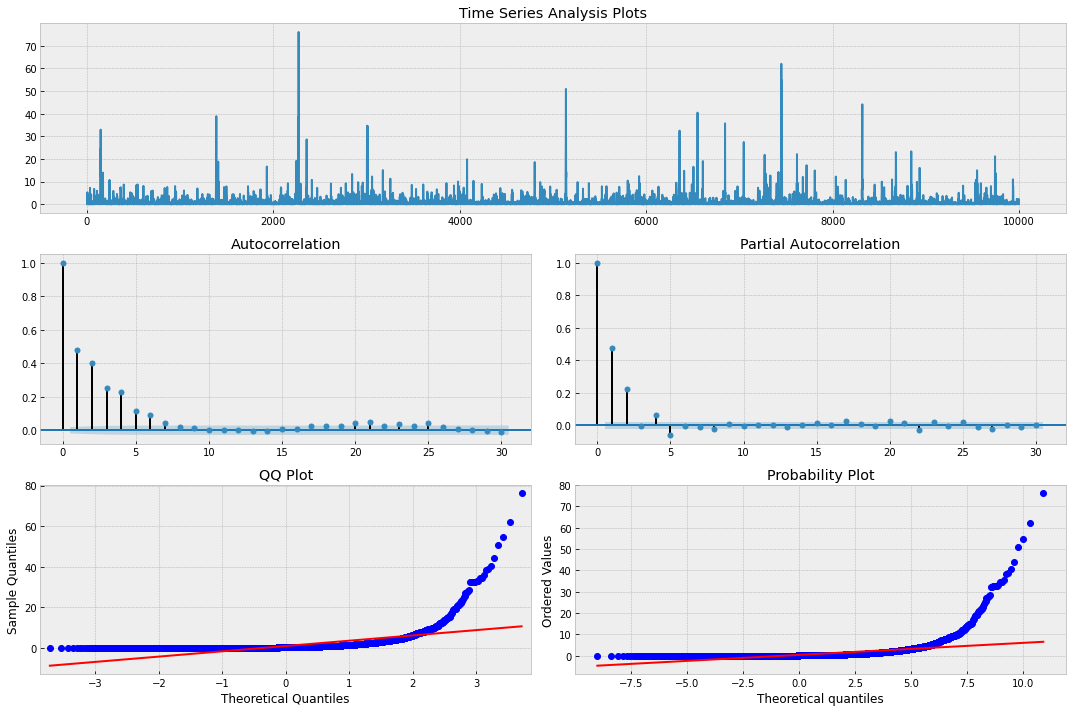

In [7]:
_ = tsplot(eps**2, lags=30)

Il existe des preuves substantielles d'un processus conditionnellement hétéroscédastique via la décomposition de retards successifs. L'importance des décalages dans le FAC et le FACP indique que nous avons besoin des composantes AR et MA pour notre modèle. Voyons si nous pouvons récupérer nos paramètres de processus en utilisant un modèle GARCH(1, 1). Nous utilisons ici la fonction arch_model du paquet ARCH.

In [8]:
# Fit a GARCH(1, 1) model to our simulated EPS series
# We use the arch_model function from the ARCH package
am = arch_model(eps)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     34,   Neg. LLF: 13129.78620620694
Iteration:     10,   Func. Count:     62,   Neg. LLF: 12237.312781005436
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12237.303267319123
            Iterations: 13
            Function evaluations: 76
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -12237.3
Distribution:                  Normal   AIC:                           24482.6
Method:            Maximum Likelihood   BIC:                           24511.4
                                        No. Observations:                10000
Date:                Wed, Sep 30 2020   Df Residuals:                     9996
Time:        

Nous pouvons voir que les véritables paramètres se situent tous dans les intervalles de confiance respectifs.

#### Application aux séries chronologiques financières
Appliquez maintenant la procédure à une série chronologique financière. Ici, nous allons utiliser les déclarations SPX. La procédure est la suivante :

Itérer par des combinaisons de modèles ARIMA(p, d, q) afin d'ajuster au mieux nos séries chronologiques.
Choisir les ordres du modèle GARCH en fonction du modèle ARIMA ayant le CIA le plus bas.
Ajuster le modèle GARCH(p, q) à notre série chronologique.
Examiner les résidus et les carrés des résidus du modèle pour l'autocorrélation
Ici, nous essayons d'abord d'adapter le retour SPX à un processus ARIMA et de trouver le meilleur ordre.

In [9]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

# Notice I've selected a specific time period to run this analysis
TS = lrets['^GSPC'].dropna()
TS.index = pd.DatetimeIndex(TS.index.values,
                               freq=TS.index.inferred_freq)
res_tup = _get_best_model(TS)

C:\Users\Nicolas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Nicolas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Nicolas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Nicolas\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it ha

aic: -5194.71619 | order: (4, 0, 0)


C:\Users\Nicolas\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


In [10]:
order = res_tup[1]
model = res_tup[2]

Comme nous avons déjà pris le journal des retours, nous devrions nous attendre à ce que notre composante intégrée d soit égale à zéro, ce qui est le cas. Nous trouvons que le meilleur modèle est ARIMA(3,0,2). Nous traçons maintenant les résidus pour décider s'ils possèdent des preuves d'un comportement hétéroscédastique conditionnel.

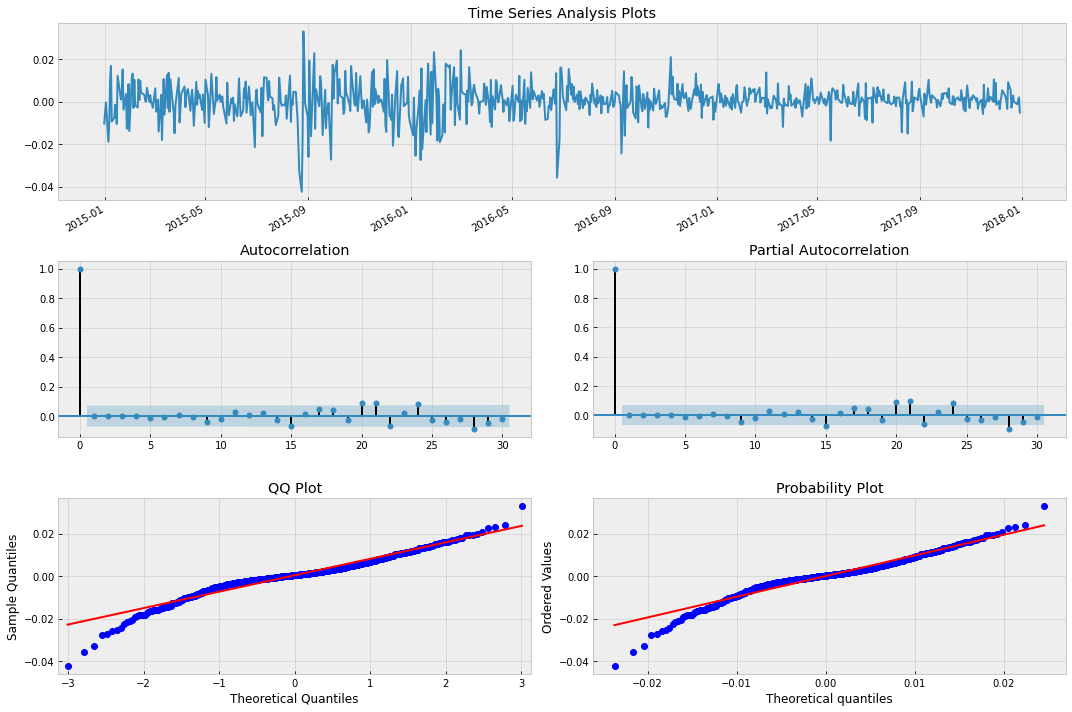

In [18]:
tsplot(model.resid, lags=30)

Nous trouvons que les residus ressemblent à un bruit blanc. Regardons le carré des résidus

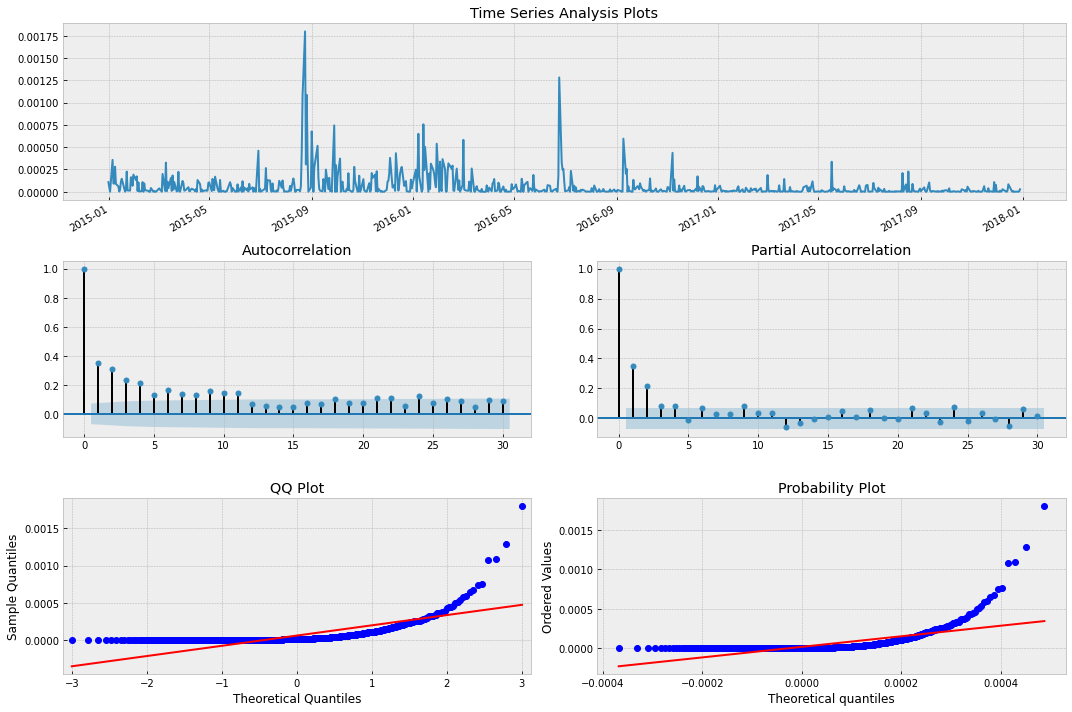

In [12]:
tsplot(model.resid**2, lags=30)

Nous pouvons voir des preuves évidentes d'autocorrélation dans le carré des résidus. Ajoutons un modèle GARCH et voyons comment il fonctionne.

In [13]:
# Now we can fit the arch model using the best fit arima model parameters

p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(model.resid, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                         Constant Mean - ARCH Model Results                         
Dep. Variable:                         None   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                             ARCH   Log-Likelihood:                2060.43
Distribution:      Standardized Student's t   AIC:                          -4106.86
Method:                  Maximum Likelihood   BIC:                          -4074.46
                                              No. Observations:                  756
Date:                      Wed, Sep 30 2020   Df Residuals:                      749
Time:                              14:22:10   Df Model:                            7
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

C:\Users\Nicolas\Anaconda3\lib\site-packages\arch\univariate\base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.977e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


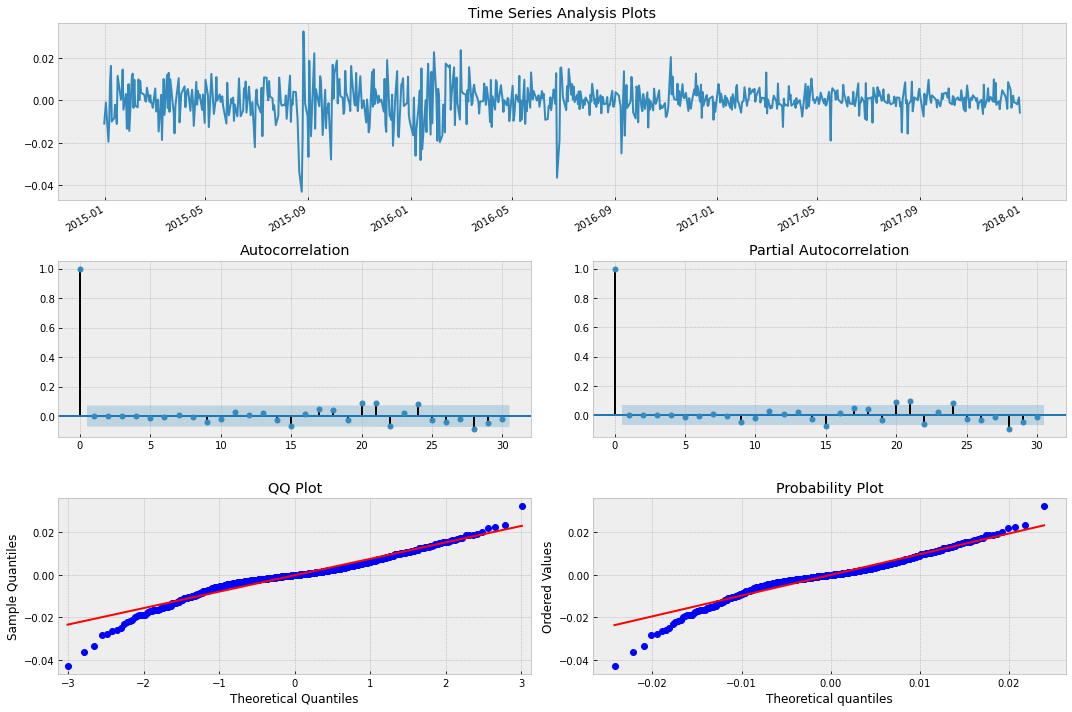

In [14]:
tsplot(res.resid, lags=30)

The plots looks like a realisation of a discrete white noise process, indicating a good fit. Let's plot a square of residuals to be sure

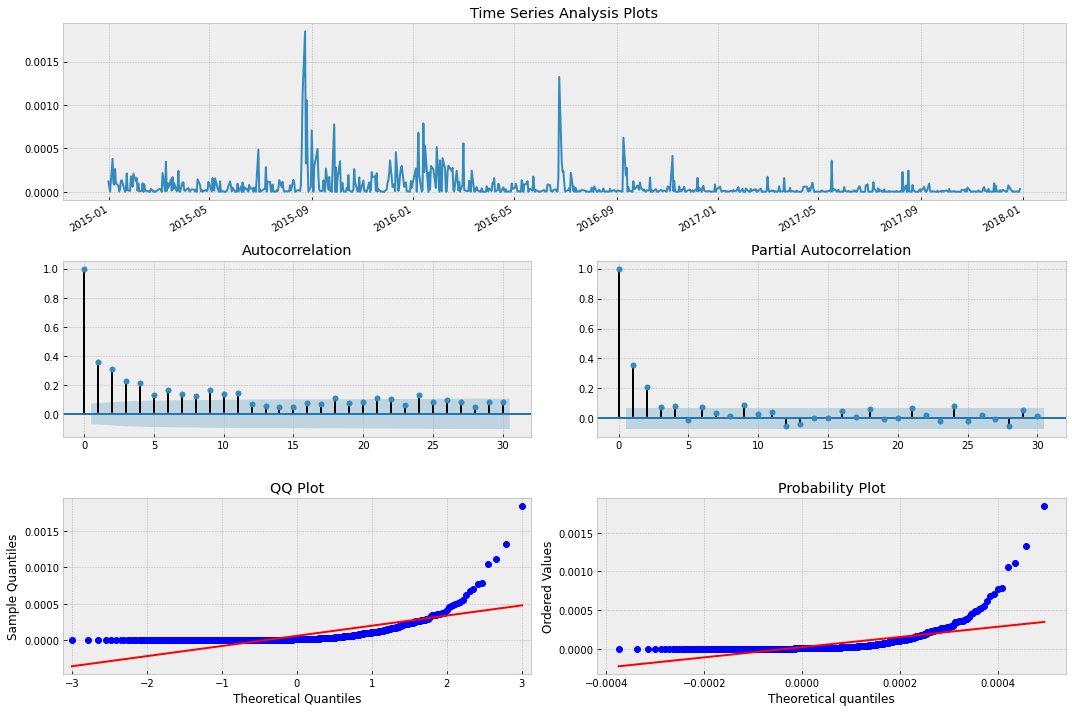

In [15]:
tsplot(res.resid**2, lags=30)

Nous avons ce qui semble être la réalisation d'un processus discret de bruit blanc, indiquant que nous avons "expliqué" la corrélation en série présente dans les résidus carrés avec un mélange approprié d'ARIMA(p,d,q) et de GARCH(p,q).


We have what looks like a realisation of a discrete white noise process, indicating that we have "explained" the serial correlation present in the squared residuals with an appropriate mixture of ARIMA(p,d,q) and GARCH(p,q).

## Next Steps

We are now at the point in our time series analysis where we have studied ARIMA and GARCH, allowing us to fit a combination of these models to a stock market index, and to determine if we have achieved a good fit or not.

The next step is to actually produce forecasts of future daily returns values from this combination and use it to create a basic trading strategy.

In [16]:
out = res.forecast(horizon=1, start=None, align='origin')
print(out.mean.iloc[-1])
print(out.variance.iloc[-1])

h.1    0.000543
Name: 2017-12-29 00:00:00, dtype: float64
h.1    0.000624
Name: 2017-12-29 00:00:00, dtype: float64


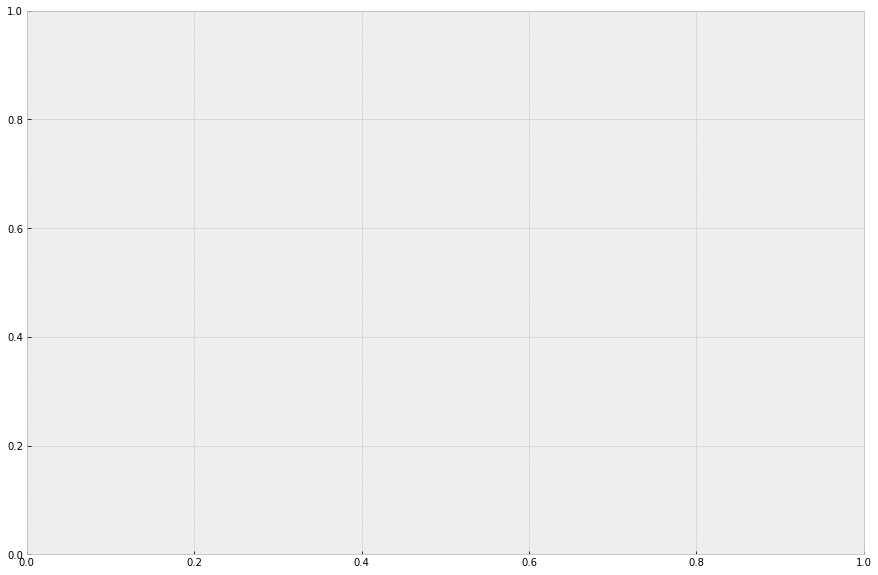

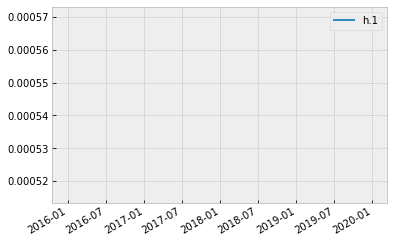

In [17]:
plt.style.use('bmh')
fig = plt.figure(figsize=(15,10))
ax = plt.gca()


# in sample prediction
#pred = best_mdl.predict(ts.index[0], ts.index[-1])
#pred.plot(ax=ax, style='r-', label='In-sample prediction')

styles = ['b-', '0.2', '0.75', '0.2', '0.75']
out.mean.plot()
plt.legend(loc='best', fontsize=10)